In [1]:
import sys
sys.path.append("../")
sys.path.append('C:\Users\James Pino\PycharmProjects\Magine')
from IPython.display import display
%matplotlib inline

In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import magine.ontology.enrichment_tools as et
from magine.plotting.heatmaps import  heatmap_from_array
from magine.plotting.wordcloud_tools import create_wordcloud

In [3]:
process_dbs = [
        'GO_Biological_Process_2017',
        'Humancyc_2016',
        'Reactome_2016',
        'KEGG_2016',
        'NCI-Nature_2016',
        'Panther_2016',
        'WikiPathways_2016',
]
enrichment_array = pd.read_csv('Data/all_cisplatin_out.csv.gz', index_col=0)

In [20]:
specific_array = et.filter_dataframe(enrichment_array, p_value=0.05, combined_score=5.0,
                                    db='Reactome_2016', category=['proteomics_up'])
rna_df = et.filter_dataframe(enrichment_array, p_value=0.05, combined_score=0.0,
                             category=['rna_up', 'rna_down'])


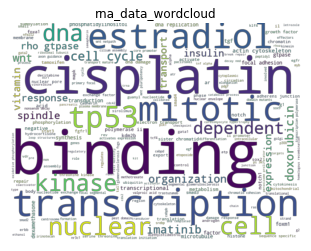

{"3' 5'": 2,
 '43s': 2,
 "5' cyclic": 2,
 'abl1': 2,
 'acetaminophen': 2,
 'acetylaminofluorene': 2,
 'acid': 8,
 'actin cytoskeleton': 10,
 'activate': 7,
 'activates expression': 4,
 'activator': 3,
 'actomyosin structure': 2,
 'adherens junction': 6,
 'adhesion': 2,
 'adipogenesis': 2,
 'age rage': 3,
 'ahr': 2,
 'akt1': 2,
 'alpha': 5,
 'anaphase': 2,
 'androgen': 5,
 'angiogenesis': 2,
 'annealing ssa': 2,
 'antiviral mechanism': 2,
 'apoptotic': 2,
 'apparatus': 2,
 'ar': 8,
 'arnt': 2,
 'assembly': 5,
 'atm': 2,
 'atp': 5,
 'atr': 4,
 'atropine': 2,
 'aurka': 2,
 'axon guidance': 4,
 'basal': 2,
 'bcr': 2,
 'bdnf': 2,
 'bexarotene': 2,
 'binding': 38,
 'biogenesis': 2,
 'biosynthesis': 3,
 'bmal1 clock': 2,
 'body': 7,
 'brd4': 2,
 'break repair': 3,
 'cadherin': 5,
 'candesartan': 2,
 'cap': 2,
 'carboplatin': 3,
 'carcinoma': 2,
 'cardiac hypertrophic': 2,
 'cardiomyocyte hypertrophy': 3,
 'catabolic process': 3,
 'catenin': 2,
 'cckr map': 2,
 'cdc42': 3,
 'cdk1': 2,
 'cdk2':

In [21]:
counts create_wordcloud(rna_df, 'rna_data_wordcloud')

In [5]:
slimmed_array = et.remove_redundant(specific_array, threshold=0.5, verbose=False)

Number of rows went from 477 to 68


In [6]:
display(slimmed_array.head(10))

,term_name,combined_score,adj_p_value,rank,genes,n_genes,db,category,sample_id
155330,Processing of Capped Intron-Containing Pre-mRN...,116.207435,4.385462e-21,1,"DDX39B,DHX9,FUS,HNRNPA0,HNRNPA1,HNRNPA2B1,HNRN...",48,Reactome_2016,proteomics_up,48hr
141152,Processing of Capped Intron-Containing Pre-mRN...,106.902995,3.188379e-19,1,"CPSF1,CSTF1,CWC15,EFTUD2,EIF4A3,FIP1L1,FUS,HNR...",46,Reactome_2016,proteomics_up,24hr
141153,Gene Expression_Homo sapiens_R-HSA-74160,102.139686,1.220822e-18,2,"AIMP2,ANP32A,ATF2,ATR,BNIP3L,BOP1,C2ORF49,CD3E...",152,Reactome_2016,proteomics_up,24hr
155332,Gene Expression_Homo sapiens_R-HSA-74160,92.138380,4.733666e-17,3,"ANP32A,APEH,BAZ1B,BDP1,BOP1,CD3EAP,CD44,CDK12,...",147,Reactome_2016,proteomics_up,48hr
155334,Metabolism of proteins_Homo sapiens_R-HSA-392499,82.654616,2.497306e-15,5,"APEH,APOA1,ARF4,ATP5A1,ATP5B,CALR,CANX,CD59,CK...",108,Reactome_2016,proteomics_up,48hr
141156,Cell Cycle_Homo sapiens_R-HSA-1640170,62.048920,6.097046e-10,5,"AKAP9,ATR,BANF1,CEP131,CNTRL,DIDO1,DKC1,DYNC1H...",62,Reactome_2016,proteomics_up,24hr
155336,Formation of ATP by chemiosmotic coupling_Homo...,56.683867,4.165819e-10,7,"ATP5A1,ATP5B,ATP5C1,ATP5D,ATP5F1,ATP5H,ATP5I,A...",11,Reactome_2016,proteomics_up,48hr
127321,Gene Expression_Homo sapiens_R-HSA-74160,55.510780,5.921719e-09,1,"AEBP2,ANP32A,ATF2,ATR,BMS1,BOP1,CPSF2,CPSF3,DA...",91,Reactome_2016,proteomics_up,06hr
155337,Hemostasis_Homo sapiens_R-HSA-109582,52.388225,1.783685e-09,8,"ACTN1,ACTN4,AHSG,ALB,ALDOA,APOA1,APOH,ATP1B1,B...",60,Reactome_2016,proteomics_up,48hr
155338,Vesicle-mediated transport_Homo sapiens_R-HSA-...,50.489896,3.569055e-09,9,"ALB,APOA1,APOE,ARF4,CALR,CD59,CHMP7,COPA,COPG2...",55,Reactome_2016,proteomics_up,48hr


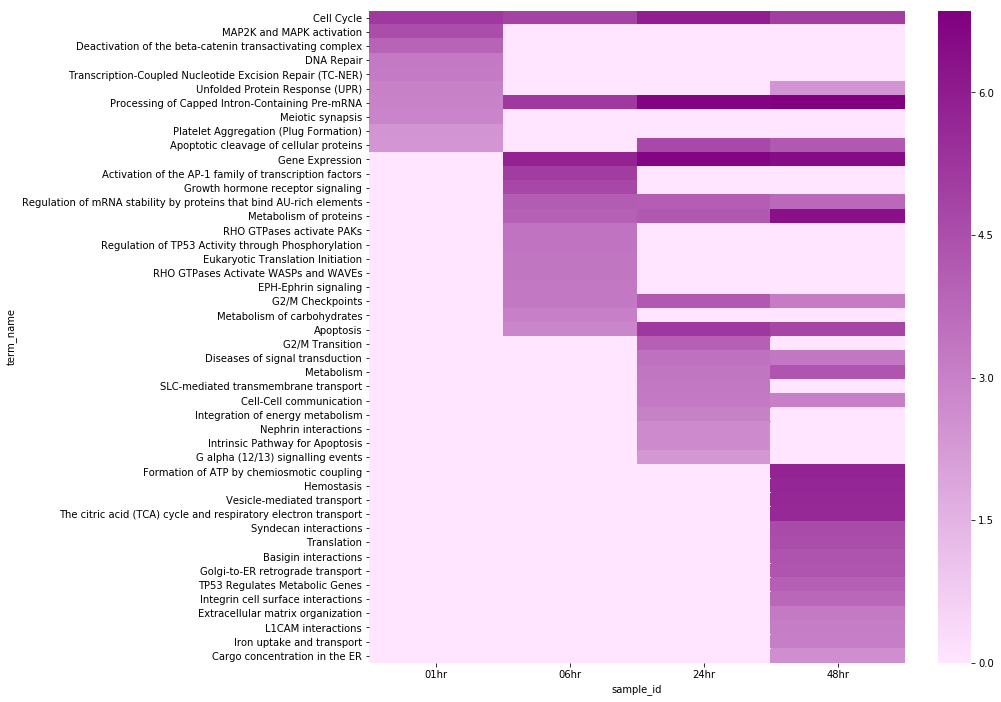

In [16]:
fig = heatmap_from_array(slimmed_array, convert_to_log=True, fig_size=(12, 12))
fig.savefig('enrichment.png', dpi=300, bbox_inches='tight')

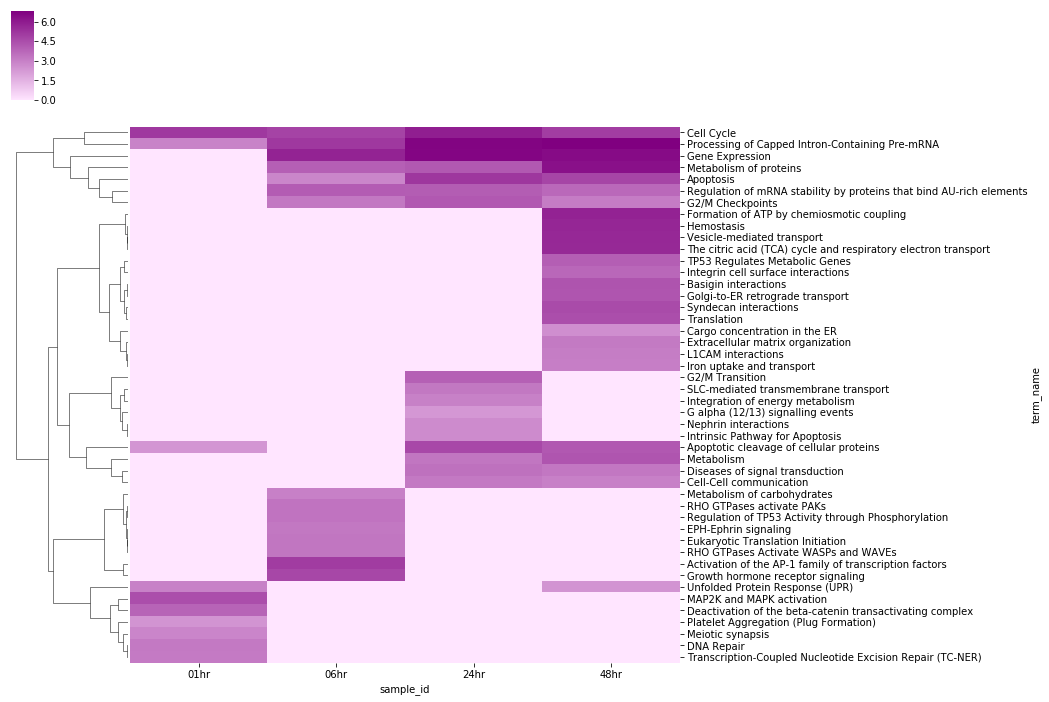

In [17]:
fig = heatmap_from_array(slimmed_array, convert_to_log=True, cluster_col=False, cluster_row=True, fig_size=(12, 12))
fig.savefig('cluster_enrichment.png', dpi=300, bbox_inches='tight')

Now lets explore the experimental data


In [9]:
d = pd.read_csv('Data/norris_et_al_2017_cisplatin_data.csv.gz', low_memory=False)
print(d['data_type'].unique())

['LF' 'SILAC' 'Ph-SILAC' 'C18' 'HILIC' 'rna_seq']


In [10]:
met = d[d['data_type'].isin(['HILIC', 'C18'])]
proteins = d[d['data_type'].isin(['LF', 'SILAC', 'Ph-SILAC', 'rna_seq'])]

print(met.shape)
print(proteins.shape)

(4810, 11)
(91092, 11)


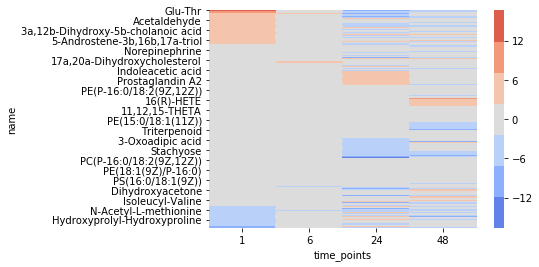

In [11]:
fig = heatmap_from_array(met, cluster_row=False, convert_to_log=True, 
                         index='name', values='treated_control_fold_change', 
                         columns='time_points', div_colors=True)

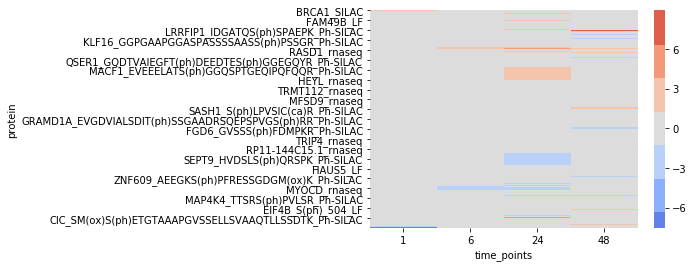

In [12]:
fig = heatmap_from_array(proteins, cluster_row=False, convert_to_log=True, 
                         index='protein', values='treated_control_fold_change', 
                         columns='time_points', div_colors=True)